## Three Stock Monte

This exercise tests your ability to retrieve stock price data using the Alpaca API and simulate multiple portfolio compositions using Monte Carlo Simulation.

### Import Dependencies

In [13]:
# Import libraries and dependencies
import os
import pandas as pd
import yfinance as yf
import datetime
from MCForecastTools import MCSimulation

In [2]:
import warnings

# Suppress the specific PerformanceWarning
warnings.filterwarnings('ignore', message='DataFrame is highly fragmented', category=pd.errors.PerformanceWarning)

In [10]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

### Get Past ~4 Year's Worth of Stock Price Data via Alpaca API Call

In [47]:
# Set start and end datetimes between now and 4 years ago.
start_date = datetime.datetime.now() - datetime.timedelta(days=1095)

# Set the ticker information
tickers = ['AGG', 'BNDX', 'SPY', 'IVW', 'IVE', 'BTC-USD', 'ETH-USD']

new_df = pd.DataFrame()
ticker_closes = []

##NOTE - we'll hardcode these for now... we can figure out what else to do w/them later
portfolio_weights = [[0.260274, 0.251875, 0.126687, 0.114389, 0.141186, 0.0, 0.105589],
                     [0.1731 , 0.1711, 0.1401, 0.1371, 0.1437, 0.1000, 0.1349],
                     [0.0941, 0.0974, 0.1473, 0.1521, 0.1415, 0.2119, 0.1557],
                     [0.0151, 0.0238, 0.1544, 0.1672, 0.1393, 0.3238, 0.1764],
                     [0.0, 0.0, 0.104690, 0.136886, 0.066593, 0.531747, 0.160084]
                     ]

# Iterate over each ticker symbol
for ticker in tickers:
    # Fetch historical stock price data for the current ticker
    stock_data = yf.download(ticker, start=start_date, end=datetime.datetime.now())
    

    stock_data = stock_data[['Close']].rename(columns={'Close': 'close'})
  
    existing_columns = stock_data.columns

    # Create a MultiIndex with a single top level and the existing column names as the second level
    multi_index = pd.MultiIndex.from_product([[ticker], existing_columns])

    # Set the MultiIndex as the columns of the DataFrame
    stock_data.columns = multi_index

    new_df = pd.concat([stock_data, new_df], axis=1)
    
    # Append the Close column name for the current ticker to the ticker_closes list
    ticker_closes.append(f'{ticker}_Close')

# Drop rows containing NaNs from the new_df dataframe
new_df.dropna(inplace=True)

print(new_df)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                ETH-USD       BTC-USD         IVE        IVW         SPY  \
                  close         close       close      close       close   
Date                                                                       
2021-05-10  3952.293945  55859.796875  150.610001  67.940002  417.940002   
2021-05-11  4168.701172  56704.574219  148.570007  67.650002  414.209991   
2021-05-12  3785.848633  49150.535156  145.990005  65.959999  405.410004   
2021-05-13  3715.148438  49716.191406  147.979996  66.660004  410.279999   
2021-05-14  4079.057373  49880.535156  149.820007  67.889999  416.579987   
...                 ...           ...         ...        ...         ...   
2024-04-29  3215.428955  63841.121094  180.910004  82.739998  510.059998   
2024-04-30  3012.286865  60636.855469  178.789993  81.239998  501.980011   
2024-05-01  2969.784668  58254.011719  178.360001  80.809998  500.350006   
2024-05-02  2988.168457  59123.433594  179.360001  81.849998  505.029999   
2024-05-03  

> Note: We're going to simulate five years of growth below, and so we might want to pull at least five years of data in order to do that. But we pulled four because of Alpaca's rate limits--we can only pull 1,000 rows per ticker at a time (approximately four years of data, with 252 tradable days per year). If we pull data with repeated calls in a `for` loop, however, we can get quite a few more years than what we've got above.  

In [26]:
stock_data = yf.download(ticker, start=start_date, end=datetime.datetime.now())
print(type(stock_data))

# Get the existing column names
existing_columns = stock_data.columns

# Create a MultiIndex with a single top level and the existing column names as the second level
multi_index = pd.MultiIndex.from_product([['ETH'], existing_columns])

# Set the MultiIndex as the columns of the DataFrame
stock_data.columns = multi_index
print(stock_data)

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
                    ETH                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2021-05-07  3490.105225  3573.290039  3370.261963  3484.729004  3484.729004   
2021-05-08  3481.988037  3950.165039  3453.768555  3902.647705  3902.647705   
2021-05-09  3911.463135  3981.259033  3743.989014  3928.844727  3928.844727   
2021-05-10  3924.413330  4197.473145  3684.451660  3952.293945  3952.293945   
2021-05-11  3948.271973  4178.208984  3783.889404  4168.701172  4168.701172   
...                 ...          ...          ...          ...          ...   
2024-05-01  3011.015625  3020.173340  2815.923340  2969.784668  2969.784668   
2024-05-02  2969.794434  3015.050293  2894.329834  2988.168457  2988.168457   
2024-05-03  2988.134521  3127.155273  2960.182129  3103.541992  3103.541992   
2024-05-04  31

### Simulate five year portfolio growth with evenly-distributed stock investments

In [50]:
# Configure a Monte Carlo simulation to forecast specified years and num_sims cumulative returns

# specify the number of simulations to be run and the number of years to be forecast
num_sims = 1000
forecast_years = 5

MC_even_dist = MCSimulation(new_df, weights=portfolio_weights[0], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_even_dist.portfolio_data.head()


ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

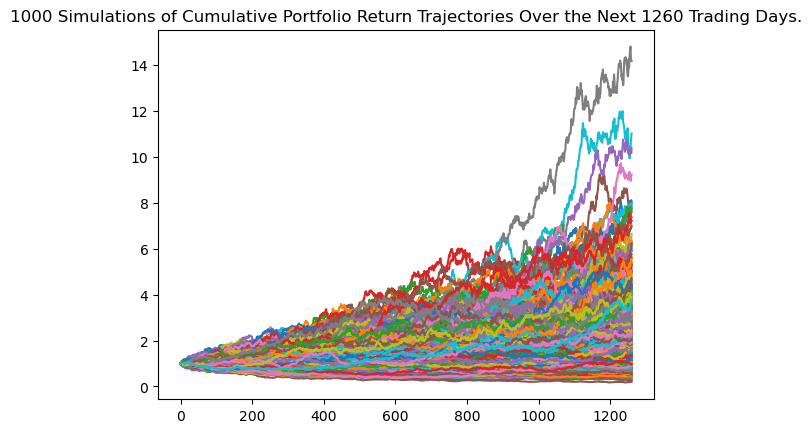

In [49]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
### ***NOTE*** WE NEED TO USE HVPLOT
MC_even_dist.plot_simulation()


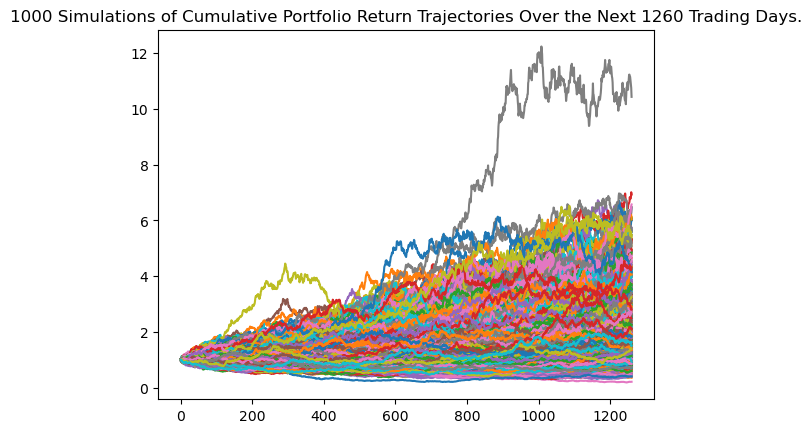

In [51]:
# Plot simulation outcomes
line_plot = MC_even_dist.plot_simulation()

#change the _fiveyear_ sim in the string to reflect the sim length
line_plot.get_figure().savefig('MC_fiveyear_sim_plot.png', bbox_inches='tight')

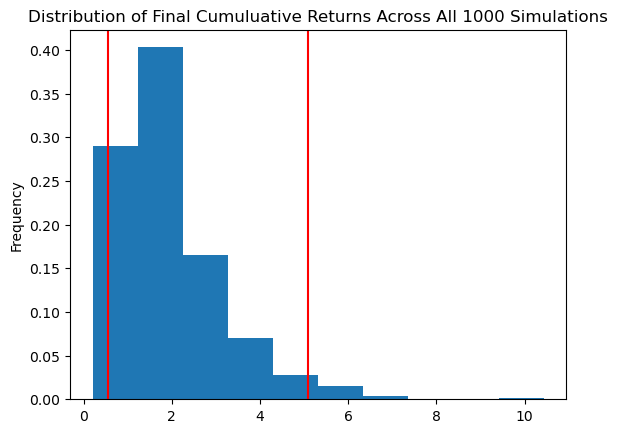

In [52]:
# Plot probability distribution and confidence intervals
dist_plot = MC_even_dist.plot_distribution()

#change the _fiveyear_ sim in the string to reflect the sim length
dist_plot.get_figure().savefig('MC_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [53]:
# Fetch summary statistics from the Monte Carlo simulation results

# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_equal = MC_even_dist.simulated_return.iloc[-1].describe()
ci_series_equal = MC_even_dist.confidence_interval
ci_series_equal.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_equal = pd.concat([summary_metrics_equal, ci_series_equal], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_equal)

count           1000.000000
mean               1.952456
std                1.166308
min                0.211171
25%                1.153846
50%                1.645988
75%                2.430853
max               10.430610
95% CI Lower       0.556119
95% CI Upper       5.092833
Name: 1260, dtype: float64


In [54]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments stocks
initial_investment = 15000
lower_bound_equal = round((summary_df_equal['95% CI Lower'] * initial_investment), 2)
upper_bound_equal = round((summary_df_equal['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment}")
print(f"in the portofolio over the next 5 years will end within the range of ${lower_bound_equal} and ${upper_bound_equal}.")

sharpe_equal = summary_df_equal['mean']/summary_df_equal['std']
print(f"this is your sharpe: {round(sharpe_equal, 2)}, you make {round(sharpe_equal,2)} units of return for every 1 unit of risk")

There is a 95% chance that an initial investment of $15000
in the portofolio over the next 5 years will end within the range of $8341.78 and $76392.49.
this is your sharpe: 1.67, you make 1.67 units of return for every 1 unit of risk


### Simulate five year portfolio growth with 60% ticker_two stock

In [55]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_ticker_two_heavy = MCSimulation(new_df, weights=portfolio_weights[1], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_ticker_two_heavy.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

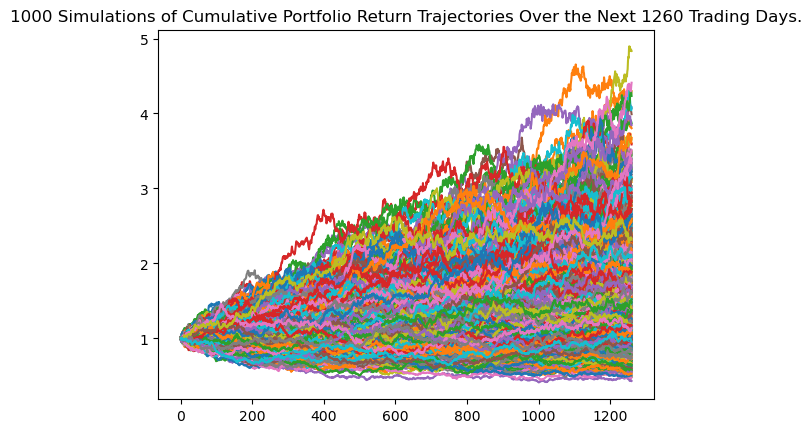

In [56]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% AT&T stock
MC_ticker_two_heavy.plot_simulation()

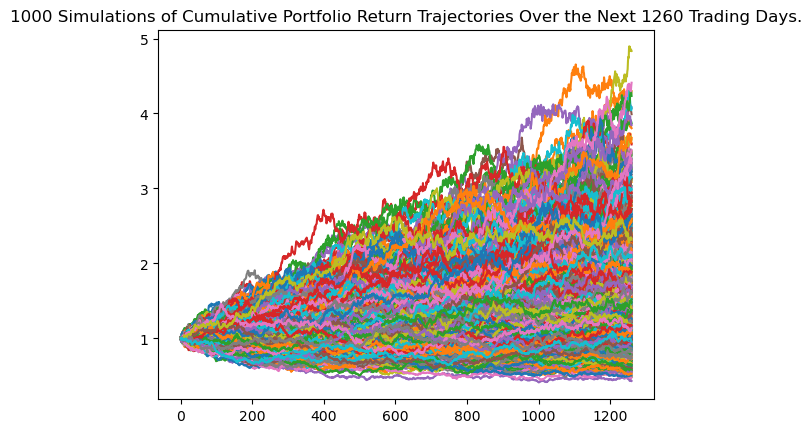

In [57]:
# Plot simulation outcomes
line_plot = MC_ticker_two_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_ATT_fiveyear_sim_plot.png', bbox_inches='tight')

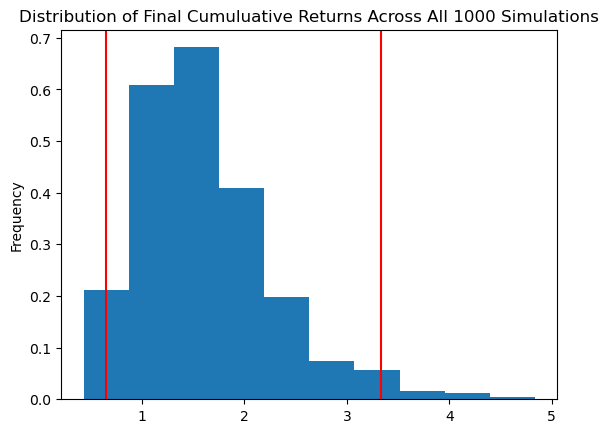

In [58]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_two_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_att_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [59]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_two_heavy = MC_ticker_two_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_two_heavy = MC_ticker_two_heavy.confidence_interval
ci_series_ticker_two_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_two_heavy = pd.concat([summary_metrics_ticker_two_heavy, ci_series_ticker_two_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_two_heavy)

count           1000.000000
mean               1.616800
std                0.659005
min                0.432656
25%                1.154295
50%                1.506272
75%                1.945931
max                4.834697
95% CI Lower       0.646191
95% CI Upper       3.331501
Name: 1260, dtype: float64


In [60]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_two_heavy = round((summary_df_ticker_two_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_two_heavy = round((summary_df_ticker_two_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_two_heavy} and ${upper_bound_ticker_two_heavy}.")


There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $9692.87 and $49972.52.


### Simulate five year portfolio growth with 60% ticker_three stock

In [61]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns with 60% Nike stock
MC_ticker_three_heavy = MCSimulation(new_df, weights=portfolio_weights[2], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Printing the simulation input data
MC_ticker_three_heavy.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

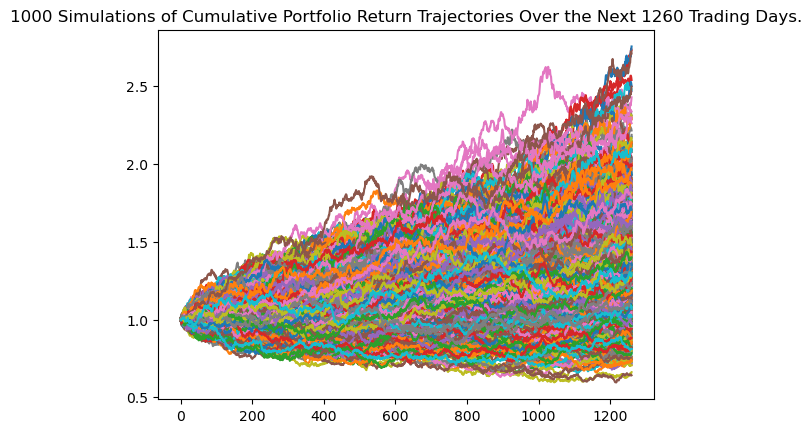

In [62]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_ticker_three_heavy.plot_simulation()

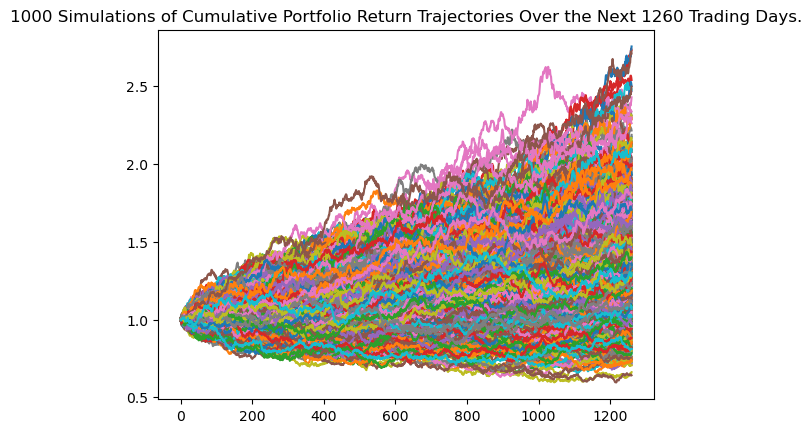

In [63]:
# Plot simulation outcomes
line_plot = MC_ticker_three_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_xom_fiveyear_sim_plot.png', bbox_inches='tight')

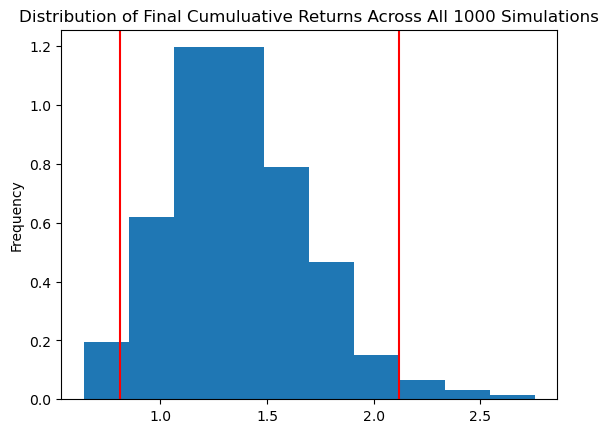

In [64]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_three_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [65]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_three_heavy = MC_ticker_three_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_three_heavy = MC_ticker_three_heavy.confidence_interval
ci_series_ticker_three_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_three_heavy = pd.concat([summary_metrics_ticker_three_heavy, ci_series_ticker_three_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_three_heavy)

count           1000.000000
mean               1.368421
std                0.334029
min                0.641549
25%                1.141456
50%                1.335523
75%                1.567278
max                2.755779
95% CI Lower       0.808626
95% CI Upper       2.116691
Name: 1260, dtype: float64


In [66]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_three_heavy = round((summary_df_ticker_three_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_three_heavy = round((summary_df_ticker_three_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_three_heavy} and ${upper_bound_ticker_three_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $12129.39 and $31750.36.


### Simulate five year portfolio growth with 60% ticker_one stock

In [67]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_ticker_one_heavy = MCSimulation(new_df, weights=portfolio_weights[3], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_ticker_one_heavy.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

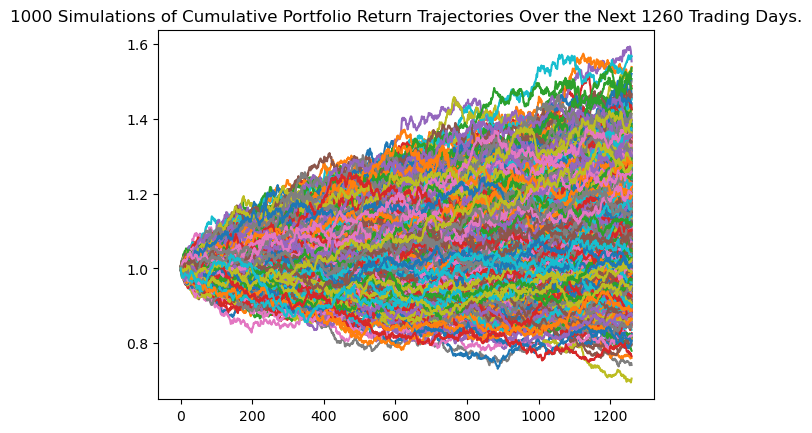

In [68]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_ticker_one_heavy.plot_simulation()

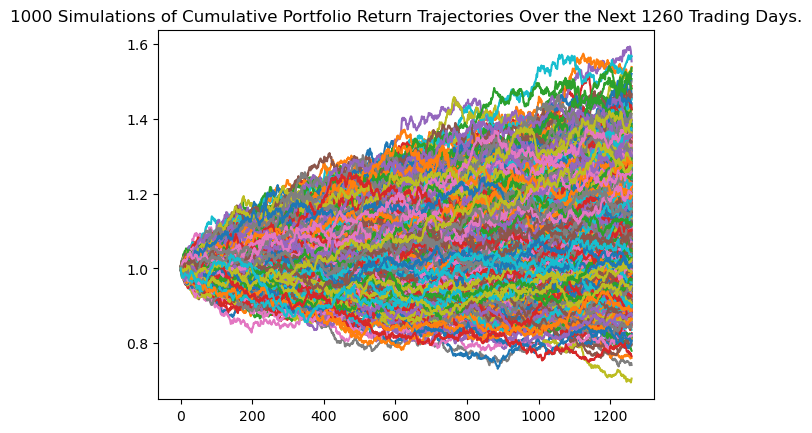

In [69]:
# Plot simulation outcomes
line_plot = MC_ticker_one_heavy.plot_simulation()

line_plot.get_figure().savefig('MC_nike_fiveyear_sim_plot.png', bbox_inches='tight')

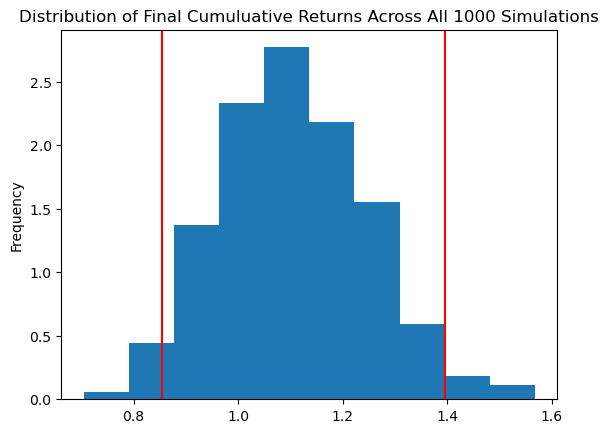

In [70]:
# Plot probability distribution and confidence intervals
dist_plot = MC_ticker_one_heavy.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [71]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_ticker_one_heavy = MC_ticker_one_heavy.simulated_return.iloc[-1].describe()
ci_series_ticker_one_heavy = MC_ticker_one_heavy.confidence_interval
ci_series_ticker_one_heavy.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_ticker_one_heavy = pd.concat([summary_metrics_ticker_one_heavy, ci_series_ticker_one_heavy], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_ticker_one_heavy)

count           1000.000000
mean               1.107167
std                0.141093
min                0.705170
25%                1.011430
50%                1.098743
75%                1.195420
max                1.567407
95% CI Lower       0.854620
95% CI Upper       1.395596
Name: 1260, dtype: float64


In [72]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_ticker_one_heavy = round((summary_df_ticker_one_heavy['95% CI Lower'] * initial_investment), 2)
upper_bound_ticker_one_heavy = round((summary_df_ticker_one_heavy['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_one_heavy} and ${upper_bound_ticker_one_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $12819.3 and $20933.94.


In [73]:
# Configuring a Monte Carlo simulation to forecast five years cumulative returns
MC_port_five = MCSimulation(new_df, weights=portfolio_weights[4], num_simulation=num_sims, num_trading_days=252*forecast_years)

# Print the simulation input data
MC_port_five.portfolio_data.head()

ETH-USD                    BTC-USD                      IVE  \
                  close daily_return         close daily_return       close   
Date                                                                          
2021-05-10  3952.293945          NaN  55859.796875          NaN  150.610001   
2021-05-11  4168.701172     0.054755  56704.574219     0.015123  148.570007   
2021-05-12  3785.848633    -0.091840  49150.535156    -0.133217  145.990005   
2021-05-13  3715.148438    -0.018675  49716.191406     0.011509  147.979996   
2021-05-14  4079.057373     0.097953  49880.535156     0.003306  149.820007   

                               IVW                      SPY               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2021-05-10          NaN  67.940002          NaN  417.940002          NaN   
2021-05-11    -0.013545  67.650002    -0.004268  414.209991    -0.008925   
2021-05-12    -0.017366  65.959999    -0.024982  405.410004    -0.021245   
2021-05-13     0.013631  66.660004     0.010613  410.279999     0.012013   
2021-05-14     0.012434  67.889999     0.018452  416.579987     0.015355   

                 BNDX                      AGG               
                close daily_return       close daily_return  
Date                                                         
2021-05-10  56.910000          NaN  114.430000          NaN  
2021-05-11  56.779999    -0.002284  114.180000    -0.002185  
2021-05-12  56.619999    -0.002818  113.779999    -0.003503  
2021-05-13  56.639999     0.000353  114.040001     0.002285  
2021-05-14  56.709999     0.001236  114.300003     0.002280

<Axes: title={'center': '1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

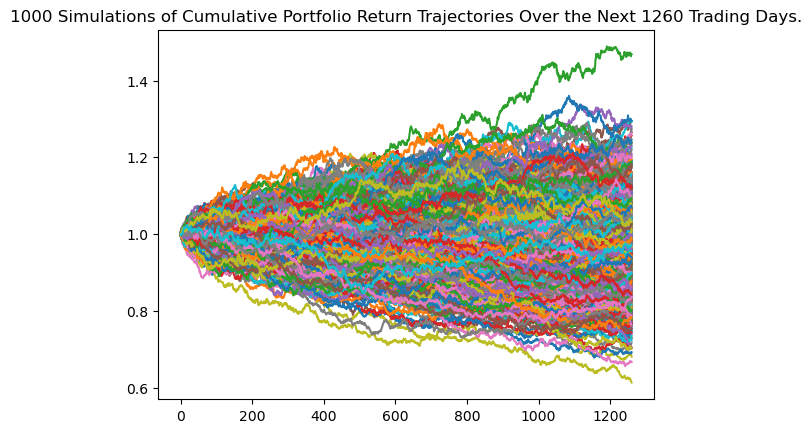

In [74]:
# Run a Monte Carlo simulation to forecast five years cumulative returns with 60% Exxon stock
MC_port_five.plot_simulation()

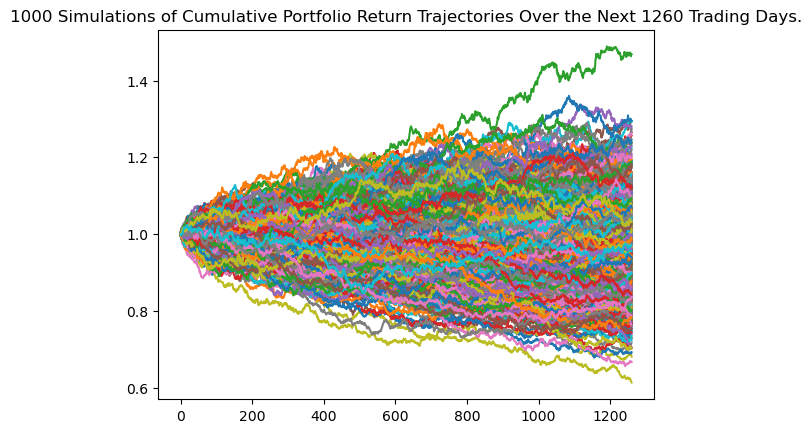

In [75]:
# Plot simulation outcomes
line_plot = MC_port_five.plot_simulation()

line_plot.get_figure().savefig('MC_nike_fiveyear_sim_plot.png', bbox_inches='tight')

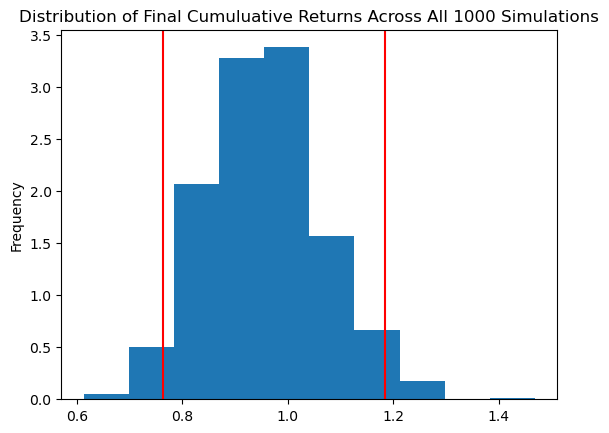

In [76]:
# Plot probability distribution and confidence intervals
dist_plot = MC_port_five.plot_distribution()

dist_plot.get_figure().savefig('MC_nike_fiveyear_dist_plot.png', bbox_inches = 'tight')

In [77]:
# Fetch summary statistics from the Monte Carlo simulation results
summary_metrics_port_five = MC_port_five.simulated_return.iloc[-1].describe()
ci_series_port_five = MC_port_five.confidence_interval
ci_series_port_five.index = ["95% CI Lower", "95% CI Upper"]

# Concatenate metrics and confidence interval series into a DataFrame
summary_df_port_five = pd.concat([summary_metrics_port_five, ci_series_port_five], axis=0)

# Print summary statistics with confidence intervals
print(summary_df_port_five)

count           1000.000000
mean               0.956262
std                0.110671
min                0.613426
25%                0.879934
50%                0.953425
75%                1.017230
max                1.468329
95% CI Lower       0.763877
95% CI Upper       1.184261
Name: 1260, dtype: float64


In [78]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments
initial_investment = 15000
lower_bound_port_five = round((summary_df_port_five['95% CI Lower'] * initial_investment), 2)
upper_bound_port_five = round((summary_df_port_five['95% CI Upper'] * initial_investment), 2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portofolio over the next 5 years will end within the range of ${lower_bound_ticker_one_heavy} and ${upper_bound_ticker_one_heavy}.")

There is a 95% chance that an initial investment of $15000 in the portofolio over the next 5 years will end within the range of $12819.3 and $20933.94.


### Summarize findings across all 4 simulations

In [79]:
# set equal portfolio metrics
risk_reward_equal = round((upper_bound_equal - initial_investment)/abs(lower_bound_equal - initial_investment), 2)
sharpe = summary_df_equal['mean']/summary_df_equal['std']
risk_adjusted_efficiency_equal = round((risk_reward_equal / sharpe), 2)

# set heavy ticker_one metrics
risk_reward_ticker_one_heavy = round((upper_bound_ticker_one_heavy - initial_investment)/abs(lower_bound_ticker_one_heavy - initial_investment), 2)
sharpe_ticker_one_heavy = summary_df_ticker_one_heavy['mean']/summary_df_ticker_one_heavy['std']
risk_adjusted_efficiency_ticker_one_heavy = round((risk_reward_ticker_one_heavy / sharpe_ticker_one_heavy), 2)

# set heavy ticker_two metrics
risk_reward_ticker_two_heavy = round((upper_bound_ticker_two_heavy - initial_investment)/abs(lower_bound_ticker_two_heavy - initial_investment), 2)
sharpe_ticker_two_heavy = summary_df_ticker_two_heavy['mean']/summary_df_ticker_two_heavy['std']
risk_adjusted_efficiency_ticker_two_heavy = round((risk_reward_ticker_two_heavy / sharpe_ticker_two_heavy), 2)

# set heavy ticker_three metrics
risk_reward_ticker_three_heavy = round((upper_bound_ticker_three_heavy - initial_investment)/abs(lower_bound_ticker_three_heavy - initial_investment), 2)
sharpe_ticker_three_heavy = summary_df_ticker_three_heavy['mean']/summary_df_ticker_three_heavy['std']
risk_adjusted_efficiency_ticker_three_heavy = round((risk_reward_ticker_three_heavy / sharpe_ticker_three_heavy), 2)

# set heavy ticker_three metrics
risk_reward_port_five = round((upper_bound_port_five - initial_investment)/abs(lower_bound_port_five - initial_investment), 2)
sharpe_port_five = summary_df_port_five['mean']/summary_df_port_five['std']
risk_adjusted_efficiency_port_five = round((risk_reward_port_five / sharpe_port_five), 2)

In [80]:
print(f"Initial Investment: ${initial_investment}")

print("--------------")
print(f'Upper and Lower Bounds of Equal Weighted: ${upper_bound_equal} and ${lower_bound_equal}')
print(f"Equal Weighted Max Profit: ${upper_bound_equal - initial_investment}")
print(f"Equal Weighted Max Loss: $ {lower_bound_equal - initial_investment}")
print(f"Equal Weighted Risk-Reward Ratio: {risk_reward_equal}")
print(f"Equal Weighted Simulation Sharpe: {round(sharpe, 2)}")
print(f"Equal Weighted Risk-Adjusted Efficiency: {risk_adjusted_efficiency_equal}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[0]} Weighted: ${upper_bound_ticker_one_heavy} and ${lower_bound_ticker_one_heavy}")
print(f"Heavy {tickers[0]} Profit: ${upper_bound_ticker_one_heavy - initial_investment}")
print(f"Heavy {tickers[0]} max loss: $ {lower_bound_ticker_one_heavy - initial_investment}")
print(f"Heavy {tickers[0]} Risk-Reward Ratio: {risk_reward_ticker_one_heavy}")
print(f"Heavy {tickers[0]} Simulation Sharpe: {round(sharpe_ticker_one_heavy, 2)}")
print(f"Heavy {tickers[0]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_one_heavy}")

print("--------------")

print(f"Upper and Lower bounds of Heavy {tickers[1]} Weighted: ${upper_bound_ticker_two_heavy} and ${lower_bound_ticker_two_heavy}")
print(f"Heavy {tickers[1]} Max Profit: ${upper_bound_ticker_two_heavy - initial_investment}")
print(f"Heavy {tickers[1]} Max Loss: $ {lower_bound_ticker_two_heavy - initial_investment}")
print(f"Heavy {tickers[1]} Risk-Reward Ratio: {risk_reward_ticker_two_heavy}")
print(f"Heavy {tickers[1]} Simulation Sharpe: {round(sharpe_ticker_two_heavy, 2)}")
print(f"Heavy {tickers[1]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_two_heavy}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[2]} Weighted: ${upper_bound_ticker_three_heavy} and ${lower_bound_ticker_three_heavy}")
print(f"Heavy {tickers[2]} Max Profit: ${upper_bound_ticker_three_heavy - initial_investment}")
print(f"Heavy {tickers[2]} Max Loss: $ {lower_bound_ticker_three_heavy - initial_investment}")
print(f"Heavy {tickers[2]} Risk-Reward Ratio: {risk_reward_ticker_three_heavy}")
print(f"Heavy {tickers[2]} Simulation Sharpe: {round(sharpe_ticker_three_heavy, 2)}")
print(f"Heavy {tickers[2]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_ticker_three_heavy}")

print("--------------")

print(f"Upper and Lower Bounds of Heavy {tickers[2]} Weighted: ${upper_bound_port_five} and ${lower_bound_port_five}")
print(f"Heavy {tickers[2]} Max Profit: ${upper_bound_port_five - initial_investment}")
print(f"Heavy {tickers[2]} Max Loss: $ {lower_bound_port_five - initial_investment}")
print(f"Heavy {tickers[2]} Risk-Reward Ratio: {risk_reward_port_five}")
print(f"Heavy {tickers[2]} Simulation Sharpe: {round(sharpe_port_five, 2)}")
print(f"Heavy {tickers[2]} Risk-Adjusted Efficiency: {risk_adjusted_efficiency_port_five}")

Initial Investment: $15000
--------------
Upper and Lower Bounds of Equal Weighted: $76392.49 and $8341.78
Equal Weighted Max Profit: $61392.490000000005
Equal Weighted Max Loss: $ -6658.219999999999
Equal Weighted Risk-Reward Ratio: 9.22
Equal Weighted Simulation Sharpe: 1.67
Equal Weighted Risk-Adjusted Efficiency: 5.51
--------------
Upper and Lower Bounds of Heavy AGG Weighted: $20933.94 and $12819.3
Heavy AGG Profit: $5933.939999999999
Heavy AGG max loss: $ -2180.7000000000007
Heavy AGG Risk-Reward Ratio: 2.72
Heavy AGG Simulation Sharpe: 7.85
Heavy AGG Risk-Adjusted Efficiency: 0.35
--------------
Upper and Lower bounds of Heavy BNDX Weighted: $49972.52 and $9692.87
Heavy BNDX Max Profit: $34972.52
Heavy BNDX Max Loss: $ -5307.129999999999
Heavy BNDX Risk-Reward Ratio: 6.59
Heavy BNDX Simulation Sharpe: 2.45
Heavy BNDX Risk-Adjusted Efficiency: 2.69
--------------
Upper and Lower Bounds of Heavy SPY Weighted: $31750.36 and $12129.39
Heavy SPY Max Profit: $16750.36
Heavy SPY Max L